In [1]:

from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from debugpy.adapter.components import missing
from networkx.algorithms.bipartite.basic import color
from pyarrow.compute import top_k_unstable

# from ydata_profiling import ProfileReport

from mastercard import dist_visualisation, dist_categorical_visualisation

2025-06-08 14:14:18.805 | INFO     | mastercard.config:<module>:11 - PROJ_ROOT path is: /home/marcin/workspace/data_sience/mastercard


In [2]:
PROCESSED_DATA_DIR = Path("../data/processed")
INTERIM_DATA_DIR = Path("../data/interim")

FIGURES_DIR = Path("../reports/figures")
df = pd.read_parquet(PROCESSED_DATA_DIR / "users.parquet")

In [3]:
transactions = pd.read_parquet(PROCESSED_DATA_DIR / "transactions.parquet")
users = pd.read_parquet(PROCESSED_DATA_DIR / "users.parquet")
merchants = pd.read_parquet(PROCESSED_DATA_DIR / "merchants.parquet")

In [4]:
users["signup_date"] = pd.to_datetime(users["signup_date"])

In [5]:
transactions.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,1,32,1,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,1,604,1,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,0,1031,1,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,1,330,0,0


In [6]:
users.head()

,user_id,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country,signup_date,risk_score
0,U00001,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079
1,U00002,36,Female,Bachelor,Business,31.60,737.76,France,2020-07-07,0.705268
2,U00003,70,Other,High School,Student Aid,275.72,1477.50,Finland,2022-08-23,0.429579
3,U00004,38,Other,High School,Savings,288.29,1135.03,Belgium,2022-05-21,0.581384
4,U00005,61,Male,High School,Employment,7.00,892.76,Italy,2022-03-15,0.420227


In [7]:
merchants.head()

,merchant_id,category,country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,M0001,travel,Austria,1.000000,3,97.23,84,0
1,M0002,clothing,Poland,0.689695,2,142.71,93,1
2,M0003,electronics,Czech Republic,0.834610,5,67.83,65,0
3,M0004,electronics,Belgium,0.607229,1,16.77,9,1
4,M0005,grocery,Ireland,0.641901,2,38.56,100,0


In [ ]:
%%sql


In [8]:
df = transactions.merge(users, on="user_id", how="left").merge(merchants, on="merchant_id", how="left", suffixes=("_users", "_merchant"))


In [9]:
print("Initial shape:", df.shape)

Initial shape: (500000, 30)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   transaction_id                  500000 non-null  object        
 1   timestamp                       500000 non-null  datetime64[ns]
 2   user_id                         500000 non-null  object        
 3   merchant_id                     500000 non-null  object        
 4   amount                          500000 non-null  float64       
 5   channel                         500000 non-null  object        
 6   currency                        500000 non-null  object        
 7   device                          500000 non-null  object        
 8   location                        500000 non-null  object        
 9   payment_method                  500000 non-null  object        
 10  is_international                500000 non-null  int64  

In [11]:
df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,country_users,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,...,Sweden,2022-08-10,0.426675,travel,France,0.581711,3,74.97,23,1
1,TX000001,2022-01-04 15:39:00,U16634,M0675,132.00,online,EUR,Android,"{'lat': 42.05935, 'long': 1.596625}",debit_card,...,France,2024-05-22,0.729627,electronics,Germany,0.568933,2,56.92,23,0
2,TX000002,2022-09-09 21:58:00,U18005,M0479,8.65,online,EUR,Android,"{'lat': 50.923432, 'long': 21.795262}",credit_card,...,Italy,2021-05-18,0.393848,gaming,Denmark,0.608070,5,98.93,75,0
3,TX000003,2023-11-20 06:40:00,U13690,M0538,19.82,mobile,EUR,iOS,"{'lat': 56.833396, 'long': -9.881566}",credit_card,...,Portugal,2021-09-05,0.393405,electronics,Portugal,0.592656,4,21.60,82,0
4,TX000004,2022-04-28 08:08:00,U04642,M0128,101.92,in-store,EUR,Android,"{'lat': 54.042996, 'long': 2.168516}",credit_card,...,Austria,2023-06-01,0.524168,gaming,Spain,0.450223,4,60.61,82,0


In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,500000,2022-12-31 16:45:04.497720576,2022-01-01 00:06:00,2022-07-01 11:03:45,2022-12-31 20:08:30,2023-07-02 08:45:15,2023-12-31 23:57:00,NaN
amount,500000.0,49.915662,0.0,14.37,34.56,69.1725,714.86,49.990657
is_international,500000.0,0.928662,0.0,1.0,1.0,1.0,1.0,0.257389
session_length_seconds,500000.0,614.987182,30.0,323.0,614.0,907.0,1200.0,338.091496
is_first_time_merchant,500000.0,0.501248,0.0,0.0,1.0,1.0,1.0,0.499999
is_fraud,500000.0,0.084822,0.0,0.0,0.0,0.0,1.0,0.278617
age,500000.0,45.951568,18.0,32.0,46.0,60.0,74.0,16.525405
sum_of_monthly_installments,500000.0,301.355199,0.01,87.43,207.33,418.0,3165.7,303.515308
sum_of_monthly_expenses,500000.0,1182.346649,0.04,353.66,825.19,1650.44,10994.33,1168.96796
signup_date,500000,2022-10-06 13:27:43.660799744,2020-04-21 00:00:00,2021-07-09 00:00:00,2022-10-08 00:00:00,2023-12-29 00:00:00,2025-03-22 00:00:00,NaN


In [13]:
df.to_parquet(INTERIM_DATA_DIR / "merge_data.parquet")

## Users  vs is_fraud


In [14]:
users_fraud = df.groupby("user_id")["is_fraud"].sum()

In [15]:
users_fraud


user_id
U00001    3
U00002    1
U00003    3
U00004    3
U00005    3
         ..
U19996    2
U19997    1
U19998    3
U19999    4
U20000    0
Name: is_fraud, Length: 20000, dtype: int64

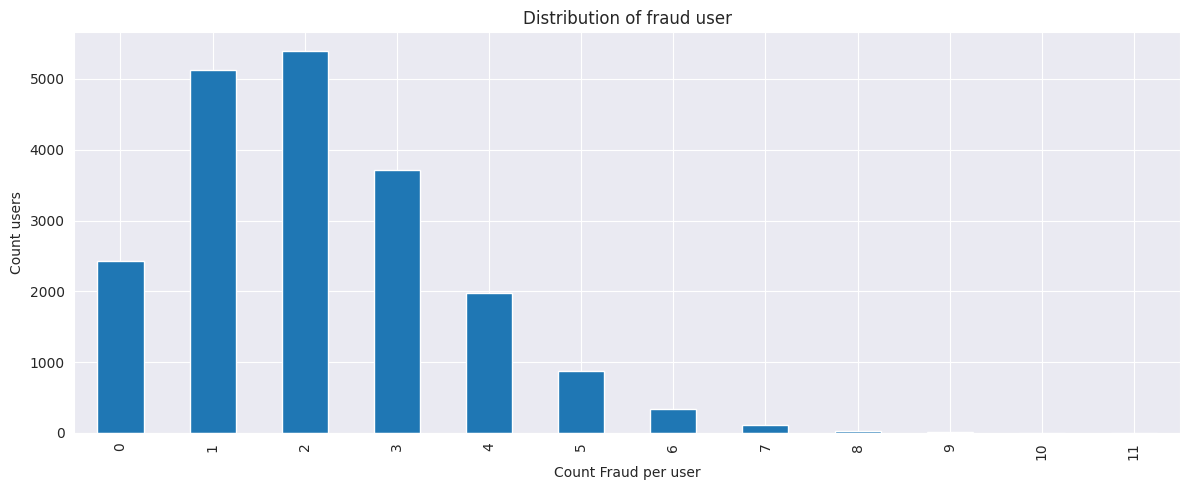

In [16]:
fig, ax = plt.subplots(figsize=(12, 5))

users_fraud.value_counts().sort_index().plot(ax=ax, kind="bar")
ax.set_xlabel("Count Fraud per user")
ax.set_ylabel("Count users")
ax.set_title("Distribution of fraud user")

fig.tight_layout()
plt.show()

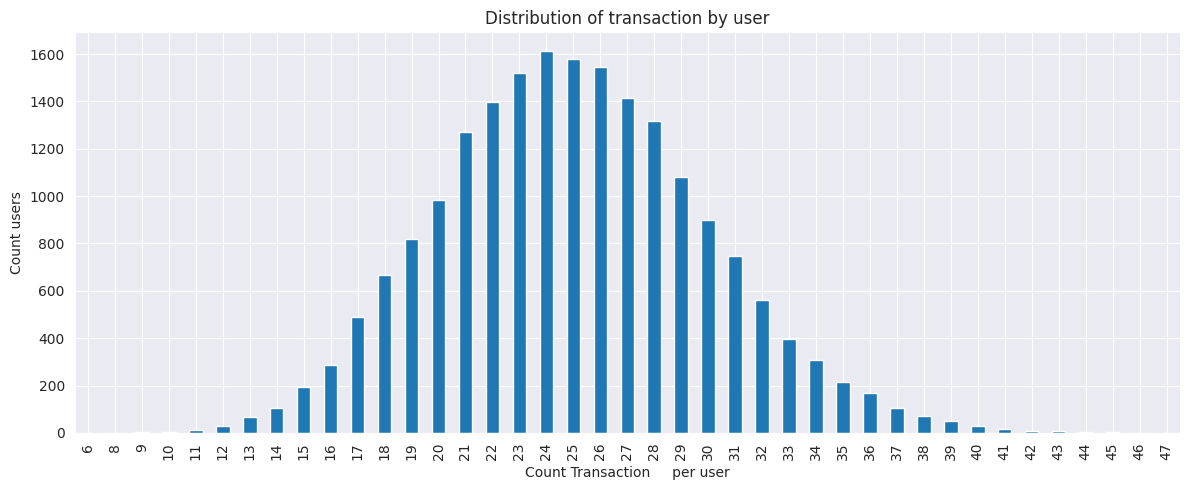

In [17]:
user_transactions = df.groupby("user_id")["transaction_id"].count()
fig, ax = plt.subplots(figsize=(12, 5))

user_transactions.value_counts().sort_index().plot(ax=ax, kind="bar")
ax.set_xlabel("Count Transaction     per user")
ax.set_ylabel("Count users")
ax.set_title("Distribution of transaction by user")

fig.tight_layout()
plt.show()

In [18]:
user_stats = (
    df.groupby("user_id")
    .agg(transactions=("is_fraud","count"), frauds=("is_fraud", "sum"))
)

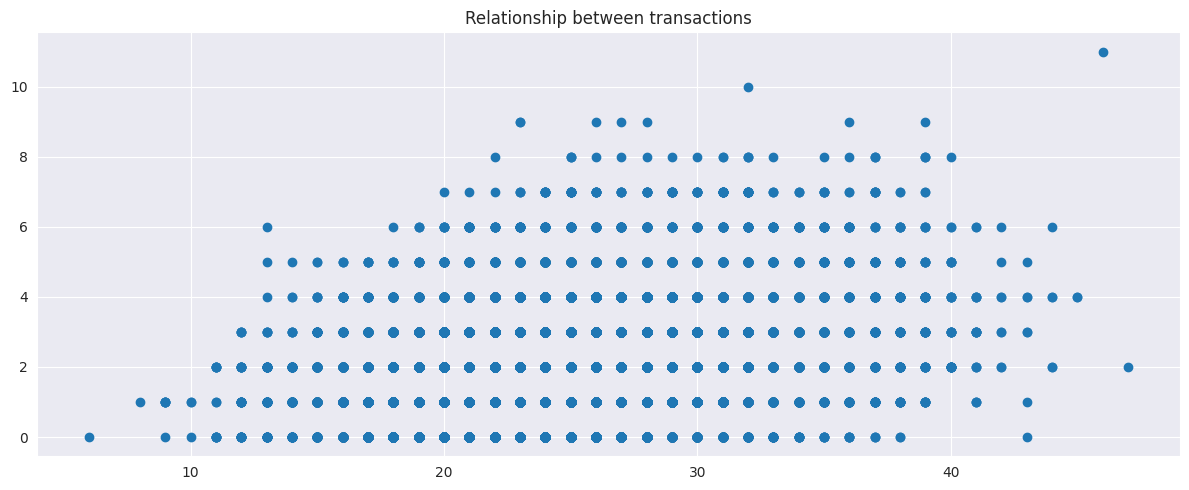

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(user_stats["transactions"], user_stats["frauds"], label="")

ax.set_label("")
ax.set_title("Relationship between transactions")



fig.tight_layout()
plt.show()

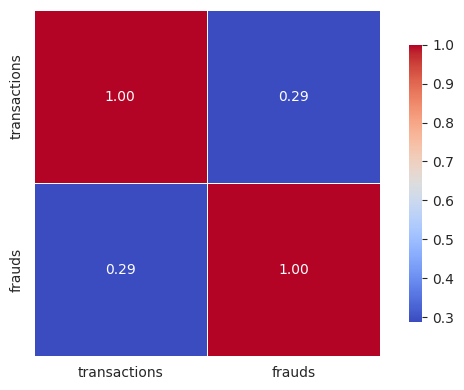

In [20]:
corr = user_stats.corr()
fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(
    corr,
    ax=ax,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8},
    cmap="coolwarm",
)

ax.set_title("", fontsize=14)
plt.tight_layout()
plt.show()

## Merchants vd fraud

In [21]:
merchant_stats = df.groupby("merchant_id").agg(transactions=("is_fraud", "count"), frauds=("is_fraud", "sum"))


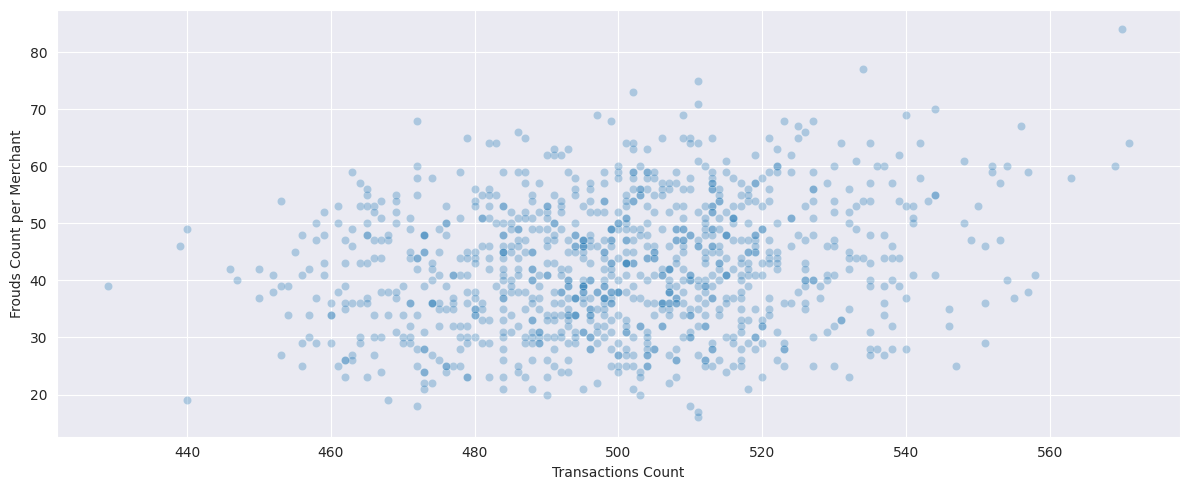

In [22]:
fig, ax = plt.subplots(figsize=(12, 5))


sns.scatterplot(
    data=merchant_stats,
    ax=ax,
    x="transactions",
    y="frauds",
    alpha=0.3
)
ax.set_title("")
ax.set_xlabel("Transactions Count")
ax.set_ylabel("Frouds Count per Merchant")


fig.tight_layout()

# plt.savefig()
plt.show()

In [23]:
fraud_by_merchant = df.groupby("merchant_id").agg(frauds=("is_fraud", "sum")).sort_values("frauds", ascending=False)

In [24]:
top_merchants = fraud_by_merchant.head(1)
df.loc[df["merchant_id"].isin(top_merchants.index)]

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,country_users,signup_date,risk_score,category,country_merchant,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
154,TX000154,2022-01-16 21:22:00,U01157,M0167,218.82,online,EUR,Web,"{'lat': 67.173166, 'long': 32.067447}",debit_card,...,Belgium,2021-05-17,0.417407,clothing,Austria,0.121984,0,77.46,78,1
1359,TX001359,2022-04-09 07:06:00,U16075,M0167,25.06,mobile,EUR,iOS,"{'lat': 68.06013, 'long': -4.49175}",credit_card,...,Czech Republic,2024-04-30,0.275460,clothing,Austria,0.121984,0,77.46,78,1
1597,TX001597,2023-11-09 17:52:00,U14985,M0167,1.61,online,EUR,Web,"{'lat': 57.376999, 'long': 12.967244}",mobile_payment,...,Finland,2024-10-01,0.306114,clothing,Austria,0.121984,0,77.46,78,1
1623,TX001623,2023-11-08 09:27:00,U09748,M0167,70.88,online,EUR,Android,"{'lat': 40.887693, 'long': 30.813473}",bank_transfer,...,Austria,2023-11-25,0.718623,clothing,Austria,0.121984,0,77.46,78,1
2349,TX002349,2022-02-22 06:19:00,U11293,M0167,10.39,online,EUR,Web,"{'lat': 52.18455, 'long': 29.82342}",mobile_payment,...,Netherlands,2021-07-01,0.401525,clothing,Austria,0.121984,0,77.46,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495521,TX495521,2023-04-09 17:09:00,U06498,M0167,24.53,online,EUR,Web,"{'lat': 52.263812, 'long': 32.602421}",bank_transfer,...,France,2023-05-20,0.409616,clothing,Austria,0.121984,0,77.46,78,1
495620,TX495620,2022-02-20 12:00:00,U15511,M0167,123.65,mobile,EUR,iOS,"{'lat': 54.094953, 'long': 38.323477}",debit_card,...,Austria,2021-05-21,0.827028,clothing,Austria,0.121984,0,77.46,78,1
496664,TX496664,2023-12-14 09:10:00,U08663,M0167,23.53,in-store,EUR,Android,"{'lat': 35.354135, 'long': 23.242417}",mobile_payment,...,Spain,2023-09-18,0.230708,clothing,Austria,0.121984,0,77.46,78,1
499416,TX499416,2023-08-22 19:03:00,U11839,M0167,15.08,online,EUR,Web,"{'lat': 39.508264, 'long': 22.168626}",bank_transfer,...,Spain,2023-03-25,0.512608,clothing,Austria,0.121984,0,77.46,78,1


### Category vs is_fraud

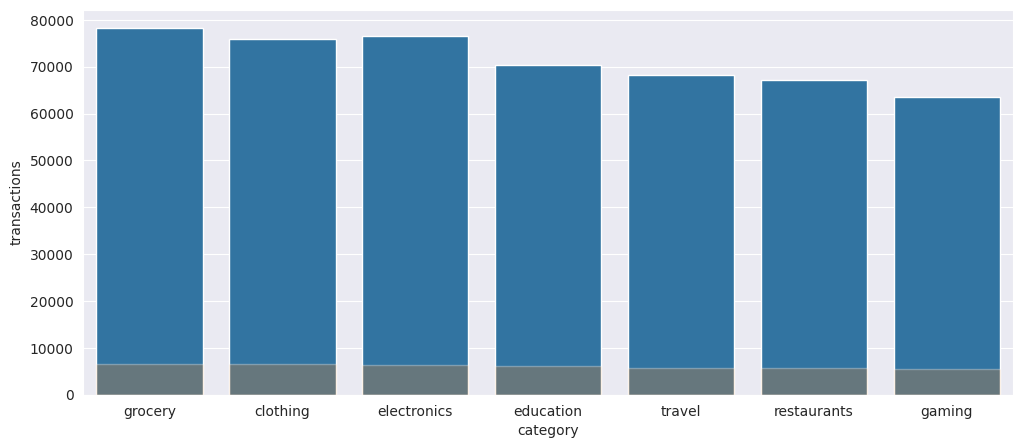

In [25]:
category_stats = df.groupby("category").agg(transactions=("is_fraud", "count"), frauds=("is_fraud", "sum")).sort_values("frauds", ascending=False)
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(
    data=category_stats,
    ax=ax,
    y="transactions",
    x="category",
    alpha=1
)
sns.barplot(
    data=category_stats,
    ax=ax,
    y="frauds",
    x="category",
    alpha=0.3
)

plt.show()

### Correlation matrix

In [26]:
df_numeric = df.select_dtypes(["number"])

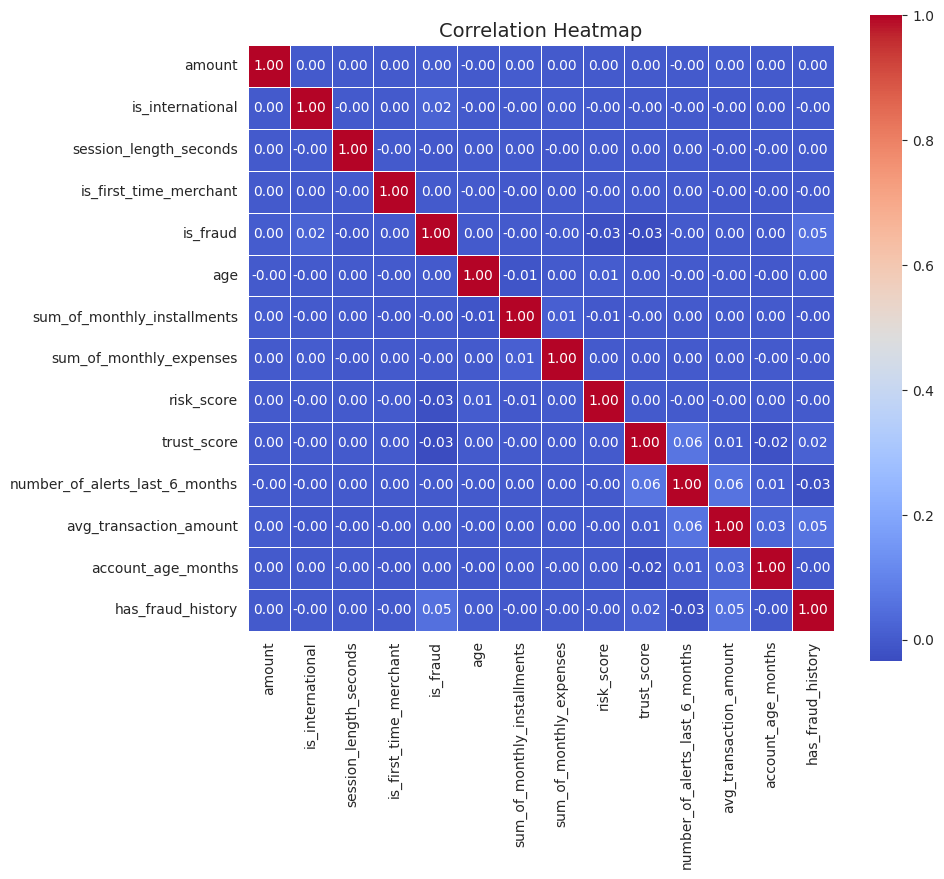

In [27]:
corr = df_numeric.corr()
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr,
    ax=ax,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": 0.8},
    cmap="coolwarm",
)

ax.set_title("Correlation Heatmap", fontsize=14)
plt.tight_layout()
plt.show()

## Categorical data

In [28]:
fraud_by_user_country = (
    df.groupby("country_users")
    .agg(frauds=("is_fraud",    "sum"), transactions=("is_fraud", "count"))
)

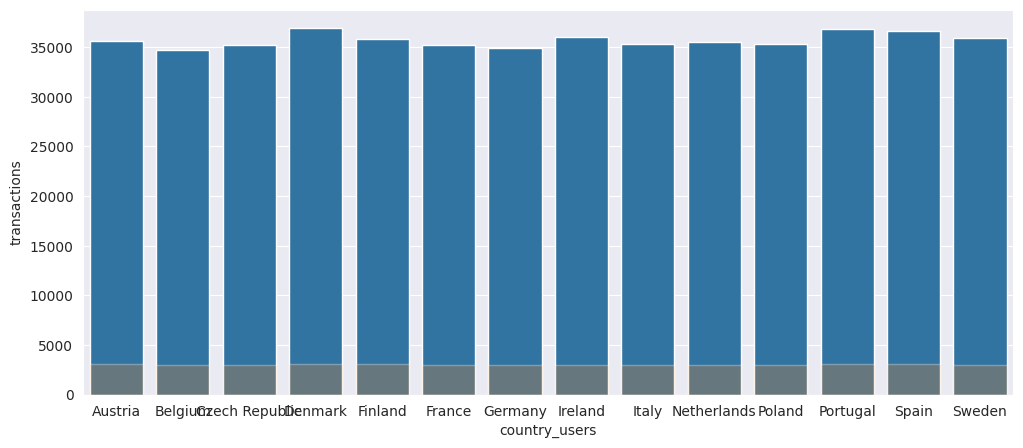

In [29]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(
    data=fraud_by_user_country,
    ax=ax,
    y="transactions",
    x="country_users",
    alpha=1
)
sns.barplot(
    data=fraud_by_user_country,
    ax=ax,
    y="frauds",
    x="country_users",
    alpha=0.3
)

plt.show()

# Fraud rate internitional vs local

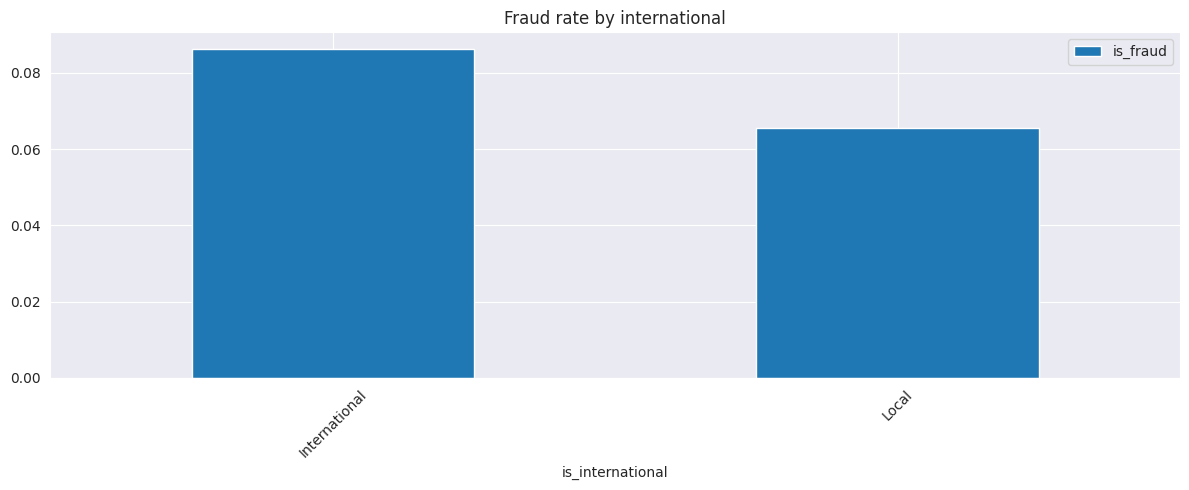

In [30]:
fraud_rate_by_international = (
    df.groupby("is_international")["is_fraud"].mean().sort_values(ascending=False)
)
fig, ax = plt.subplots(figsize=(12, 5))

fraud_rate_by_international.plot(ax=ax, kind="bar")

ax.set_label("")
ax.set_title("Fraud rate by international")
ax.set_xticklabels(["International", "Local"], rotation=45, ha="center")

ax.legend()


fig.tight_layout()
plt.show()

In [31]:
# df.loc[(df['country_users'] != df["country_merchant"]) & (df["is_international"] == 0)]



In [32]:
fig = px.choropleth(
    df.groupby("country_merchant")['is_fraud'].sum().reset_index(),
    locations="country_merchant",
    locationmode="country names",
    color="is_fraud",
    color_continuous_scale="Reds",
    title="Number of frauds by merchant",
)
fig.show()

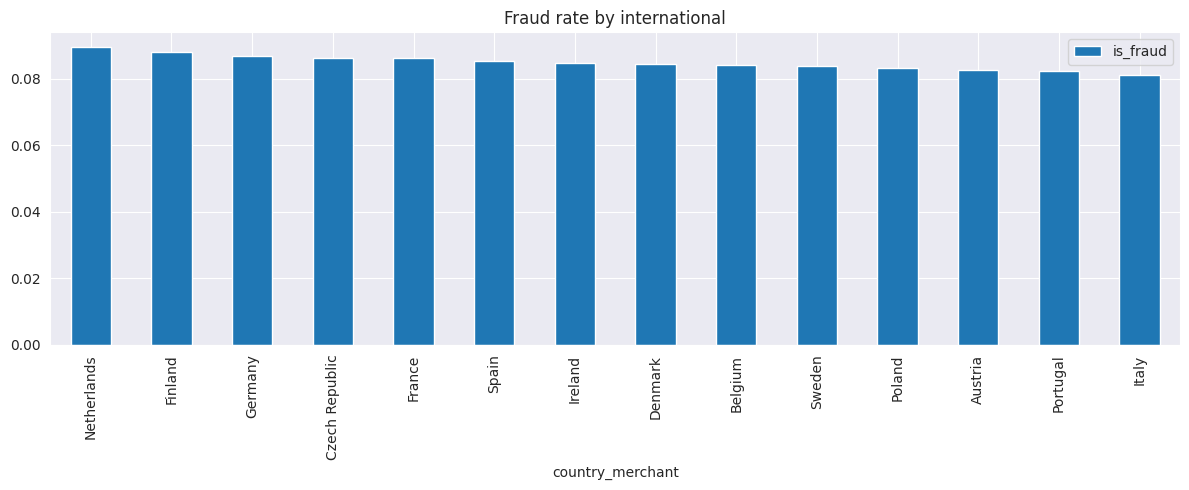

In [33]:
fraud_rate_by_country_merchant = (
    df.groupby("country_merchant")["is_fraud"].mean().sort_values(ascending=False)
)
fig, ax = plt.subplots(figsize=(12, 5))

fraud_rate_by_country_merchant.plot(ax=ax, kind="bar")

ax.set_label("")
ax.set_title("Fraud rate by international")


ax.legend()


fig.tight_layout()
plt.show()

In [34]:
df["from_to"] = df["country_users"] + df["country_merchant"]

In [35]:
df.loc[df['is_international'] == 1].groupby("from_to")['is_fraud'].mean().sort_values(ascending=False)

from_to
GermanyNetherlands    0.102744
FinlandNetherlands    0.101657
FinlandAustria        0.098967
PolandFrance          0.098208
AustriaSpain          0.097768
                        ...   
SwedenItaly           0.076726
SwedenIreland         0.076639
DenmarkSweden         0.076386
SpainAustria          0.075221
PortugalSweden        0.075127
Name: is_fraud, Length: 182, dtype: float64

/tmp/ipykernel_78237/3022995297.py:21: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



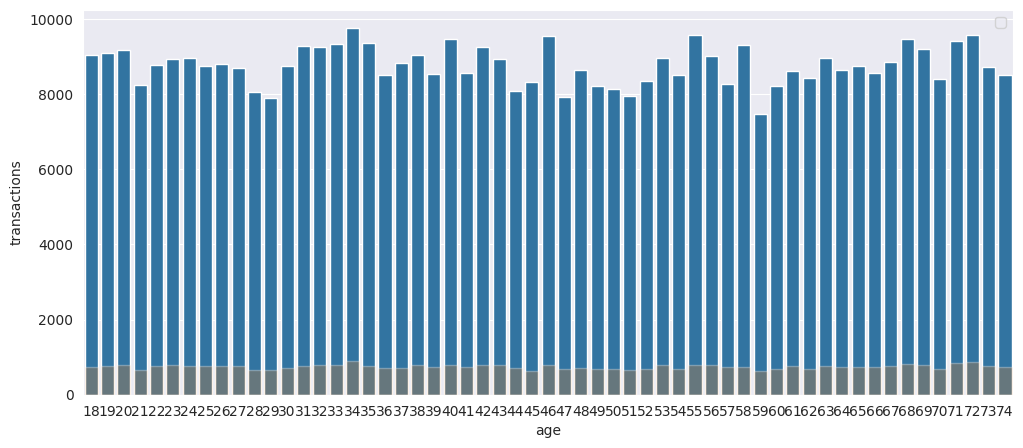

In [36]:
stats = (
    df.groupby("age")
    .agg(frauds=("is_fraud", "sum"), transactions=("is_fraud", "count"))
)
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(
    data=stats,
    ax=ax,
    y="transactions",
    x="age",
    alpha=1
)
sns.barplot(
    data=stats,
    ax=ax,
    y="frauds",
    x="age",
    alpha=0.3
)
ax.legend()

plt.show()

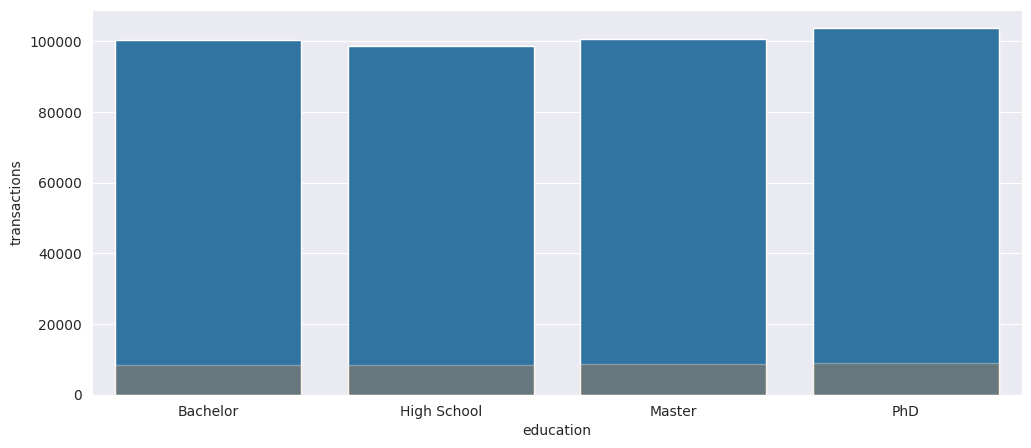

In [37]:
stats = (
    df.groupby("education")
    .agg(frauds=("is_fraud", "sum"), transactions=("is_fraud", "count"))
)
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(
    data=stats,
    ax=ax,
    y="transactions",
    x="education",
    alpha=1
)
sns.barplot(
    data=stats,
    ax=ax,
    y="frauds",
    x="education",
    alpha=0.3
)


plt.show()

In [38]:
df.loc[df["timestamp"] < df['signup_date']].value_counts["is_fraud"]

TypeError: 'method' object is not subscriptable